**This notebook contains our functions that preprocessed the data as well as our EDA**

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
#import json
#import requests

from itertools import permutations
from geopy.geocoders import Nominatim
from geopy.distance import great_circle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

sns.set_style('darkgrid')

#Connection with Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

#Set the current directory
import os
os.chdir('/content/drive/My Drive/Advanced_Python_Project')

Mounted at /content/drive/


### Functions

In [3]:
cache = {} # Define a cache dictionary to store the geocoded addresses

def find_area(latitude, longitude):

    location_key = f"{latitude},{longitude}"
    if location_key in cache: 
        return cache[location_key]
    else:
        location = Nominatim(user_agent="my_app")
        address = location.reverse(f"{latitude}, {longitude}").address.split(',')

        for idx, area in enumerate(address):
          if area.find('Jersey City') != -1: # If Jersey City is in the address
            if idx == 0: 
              result = area.strip() # County is the first area
              break
            else: 
              result = address[idx-1].strip()
              break

          elif area.find('County') != -1: # If County is in the address
            if idx == 0: 
              result = area.strip() # County is the first area
              break
            else: 
              result = address[idx-1].strip()
              break

          elif area.find('Queens') != -1: # If Queens is in the address
            if idx == 0: 
              result = area.strip() # Queens is the first area
              break
            else: 
              result = address[idx-1].strip()
              break

          elif area.find('Staten Island') != -1: # If Staten Island is in the address
            if idx == 0: 
              result = area.strip() # Staten Island is the first area
              break
            else: 
              result = address[idx-1].strip()
              break

          else: 
            result = address[0]

        cache[location_key] = result
        return result

In [7]:
def data_preprocessing(df, inplace=True):

    # Extract date specifics
    df['key'] = pd.to_datetime(df['key'])
    df['hour'] = df['key'].dt.hour
    df['day_of_week'] = df['key'].dt.dayofweek
    df['week_of_year'] = df['key'].dt.isocalendar().week
    df['year'] = df['key'].dt.year

    # Drop passenger count below 1 or above 6
    start_time = time()
    passenger_idx = list(df[(df['passenger_count'] == 0) | (df['passenger_count'] > 6)].index)
    df = df.drop(passenger_idx)
    print('Dropping trips with 0 passengers and more than 6 passengers ({} dropped) ~{} seconds'.format(len(passenger_idx), round(time() - start_time, 2)))
    
    # Drop fare rides below $3 and above $150 ($3 is the minimum flat rate + minumum mile rate in 2015)
    start_time = time()
    fare_idx = list(df[(df['fare_amount'] < 3) | (df['fare_amount'] > 150)].index)
    df = df.drop(fare_idx)
    print('Dropping fares below $3 and above $150 ({} dropped) ~{} seconds'.format(len(fare_idx), round(time() - start_time, 2)))

    # Drop rides outside focus area
    start_time = time()
    minLong, maxLong = -74.3, -73.5
    minLat, maxLat = 40.5, 41

    location_idx = []
    location_idx += list(df[(df['pickup_latitude'] < minLat) | (df['pickup_latitude'] > maxLat)].index)
    location_idx += list(df[(df['pickup_longitude'] < minLong) | (df['pickup_longitude'] > maxLong)].index)
    location_idx += list(df[(df['dropoff_latitude'] < minLat) | (df['dropoff_latitude'] > maxLat)].index)
    location_idx += list(df[(df['dropoff_longitude'] < minLong) | (df['dropoff_longitude'] > maxLong)].index)
    df = df.drop(location_idx)
    print('Dropping trips outside of the focus region ({} dropped)  ~{} seconds'.format(len(location_idx), round(time() - start_time, 2)))

    # Create geographical distance column 
    start_time = time()
    print('Creating geographical distance column')
    df['distance'] = df.apply(lambda x: great_circle((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).km, axis=1)
    print('Geographical distance column created! ~{} seconds'.format(round(time() - start_time, 2)))

    # Drop rides with low distance and an excessively high fare
    start_time = time()
    fare2_idx = list(df[(df['fare_amount'] > 40) & (df['distance'] <= 1)].index)
    df = df.drop(fare2_idx)
    print('Dropping rides with low distance (< 1 km) and an excessively high fare (>$40) ({} dropped) ~{} seconds'.format(len(fare2_idx), round(time() - start_time, 2)))

    # Create the pickup and dropoff area columns (round coordinates to first decimalto be able to apply caching)
    print('Creating pickup/dropoff area columns')
    df['pickup_longitude_rounded'] = df['pickup_longitude'].apply(lambda x: round(x, 1)) 
    df['pickup_latitude_rounded'] = df['pickup_latitude'].apply(lambda x: round(x, 1)) 
    df['dropoff_longitude_rounded'] = df['dropoff_longitude'].apply(lambda x: round(x, 1)) 
    df['dropoff_latitude_rounded'] = df['dropoff_latitude'].apply(lambda x: round(x, 1))
    
    start_time = time()
    df['pickup_area'] = df.apply(lambda x: find_area(x["pickup_latitude_rounded"], x["pickup_longitude_rounded"]), axis=1)
    print('Pickup area column created! ~{} seconds'.format(round(time() - start_time, 2)))
    start_time = time()
    df['dropoff_area'] = df.apply(lambda x: find_area(x["dropoff_latitude_rounded"], x["dropoff_longitude_rounded"]), axis=1)
    print('Dropoff area column created! ~{} seconds'.format(round(time() - start_time, 2)))

    # Drop unused columns
    df = df.drop(['key', 'pickup_datetime', 'dropoff_latitude_rounded', 'dropoff_longitude_rounded', 'pickup_latitude_rounded', 'pickup_longitude_rounded'], axis=1)
    
    print('This dataset contains {} rows and {} columns ({} rows dropped)'.format(df.shape[0], df.shape[1], len(passenger_idx) + len(fare_idx) + len(location_idx)))
    return df.reset_index(drop=True)
      

### Read data

In [5]:
raw_df = pd.read_csv('./Data/train.csv', nrows = 5_000_000)
print('This dataset contains {} rows and {} columns'.format(raw_df.shape[0], raw_df.shape[1]))
raw_df.head()

This dataset contains 5000000 rows and 8 columns


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
df = data_preprocessing(raw_df, inplace=True)

Dropping trips with 0 passengers and more than 6 passengers (17651 dropped) ~1.11 seconds
Dropping fares below $3 and above $150 (33180 dropped) ~1.55 seconds
Dropping trips outside of the focus region (394138 dropped)  ~1.39 seconds
Creating geographical distance column
Geographical distance column created! ~158.14 seconds
Dropping rides with low distance (< 1 km) and an excessively high fare (>$40) (9402 dropped) ~1.5 seconds
Creating pickup/dropoff area columns


Pickup area column created! ~82.63 seconds
Dropoff area column created! ~63.27 seconds
This dataset contains 4834268 rows and 13 columns (444969 rows dropped)


In [9]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,week_of_year,year,distance,pickup_area,dropoff_area
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,0,25,2009,1.030765,Jamaica,Jamaica
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,2010,8.450146,Manhattan,North Bergen
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,3,33,2011,1.389527,North Bergen,North Bergen
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,5,16,2012,2.799274,Manhattan,North Bergen
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,1,10,2010,1.999160,North Bergen,North Bergen


### Visualizations

#### Univariate

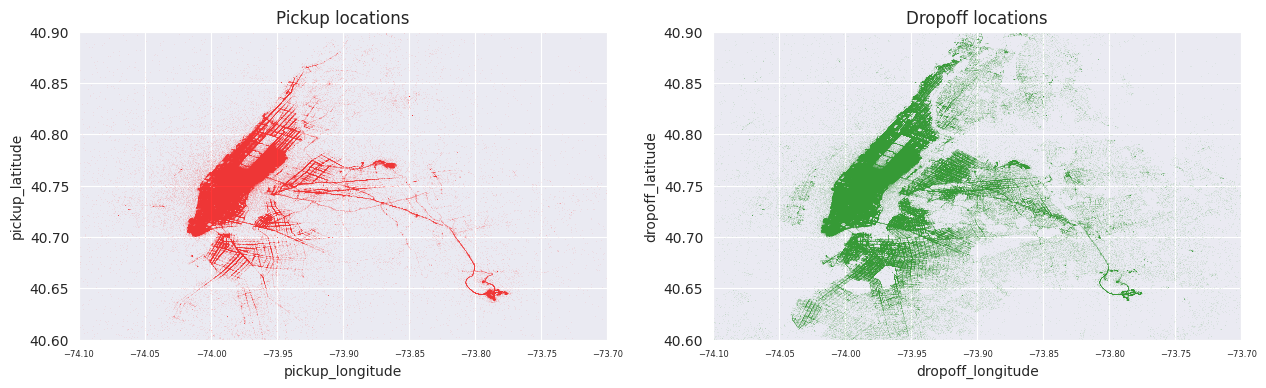

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].set_title('Pickup locations')
sns.scatterplot(ax=axes[0], data=df, x='pickup_longitude', y='pickup_latitude', color='red', s=.04, alpha=1)
axes[1].set_title('Dropoff locations')
sns.scatterplot(ax=axes[1], data=df, x='dropoff_longitude', y='dropoff_latitude', color='green', s=.04, alpha=1)

axes[0].set_xlim(-74.1, -73.7)
axes[1].set_xlim(-74.1, -73.7)
axes[0].set_ylim(40.6, 40.9)
axes[1].set_ylim(40.6, 40.9)
plt.show()

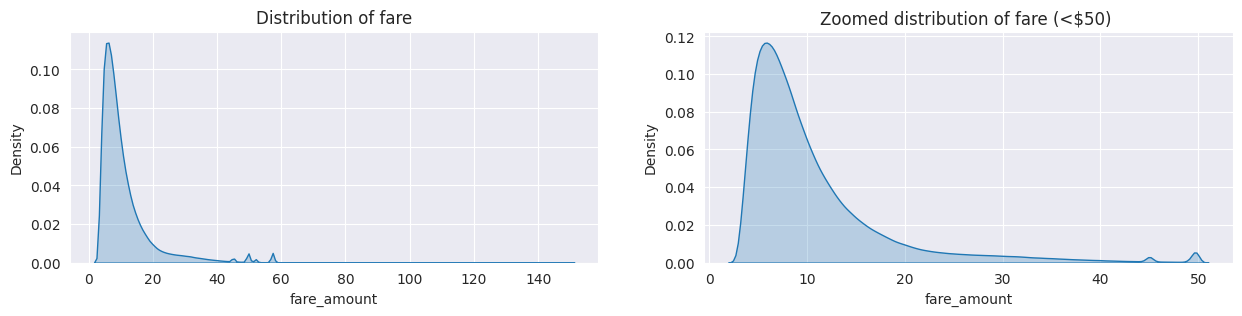

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
sns.kdeplot(ax=axes[0], data=df['fare_amount'], fill=True)
axes[0].set_title('Distribution of fare')
sns.kdeplot(ax=axes[1], data=df[df['fare_amount'] < 50]['fare_amount'], fill=True)
axes[1].set_title('Zoomed distribution of fare (<$50) ')
plt.show()

In [26]:
df[df['fare_amount'] > 40]['fare_amount'].value_counts()

57.33     20644
49.80     14058
45.00     10598
49.57      8914
52.00      8280
          ...  
118.15        1
80.12         1
132.29        1
85.20         1
67.66         1
Name: fare_amount, Length: 2185, dtype: int64

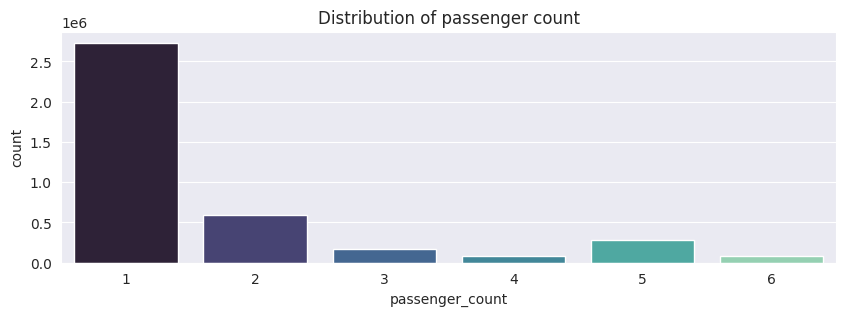

In [ ]:
plt.figure(figsize=(10, 3))
plt.title('Distribution of passenger count')
sns.countplot(x=df['passenger_count'], palette='mako')
plt.show()

In [16]:
pd.concat([df['pickup_area'].value_counts(), df['dropoff_area'].value_counts()], axis=1).head(10)

,pickup_area,dropoff_area
North Bergen,2465441,2408877
Manhattan,1994927,1895930
Port Morris,251923,313379
Somerville,68885,31632
Ridgewood,32196,92739
Jamaica,9295,21459
Brooklyn,3791,24189
Riverdale,2278,22281
Beechhurst,1802,7222
Greenville,706,919


#### Multivariate

<ipython-input-11-9ea4ffb9ccb5>:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[row, col], data=df[df['pickup_area'] == area]['fare_amount'], fill=True)
<ipython-input-11-9ea4ffb9ccb5>:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[row, col], data=df[df['pickup_area'] == area]['fare_amount'], fill=True)
<ipython-input-11-9ea4ffb9ccb5>:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[row, col], data=df[df['pickup_area'] == area]['fare_amount'], fill=True)


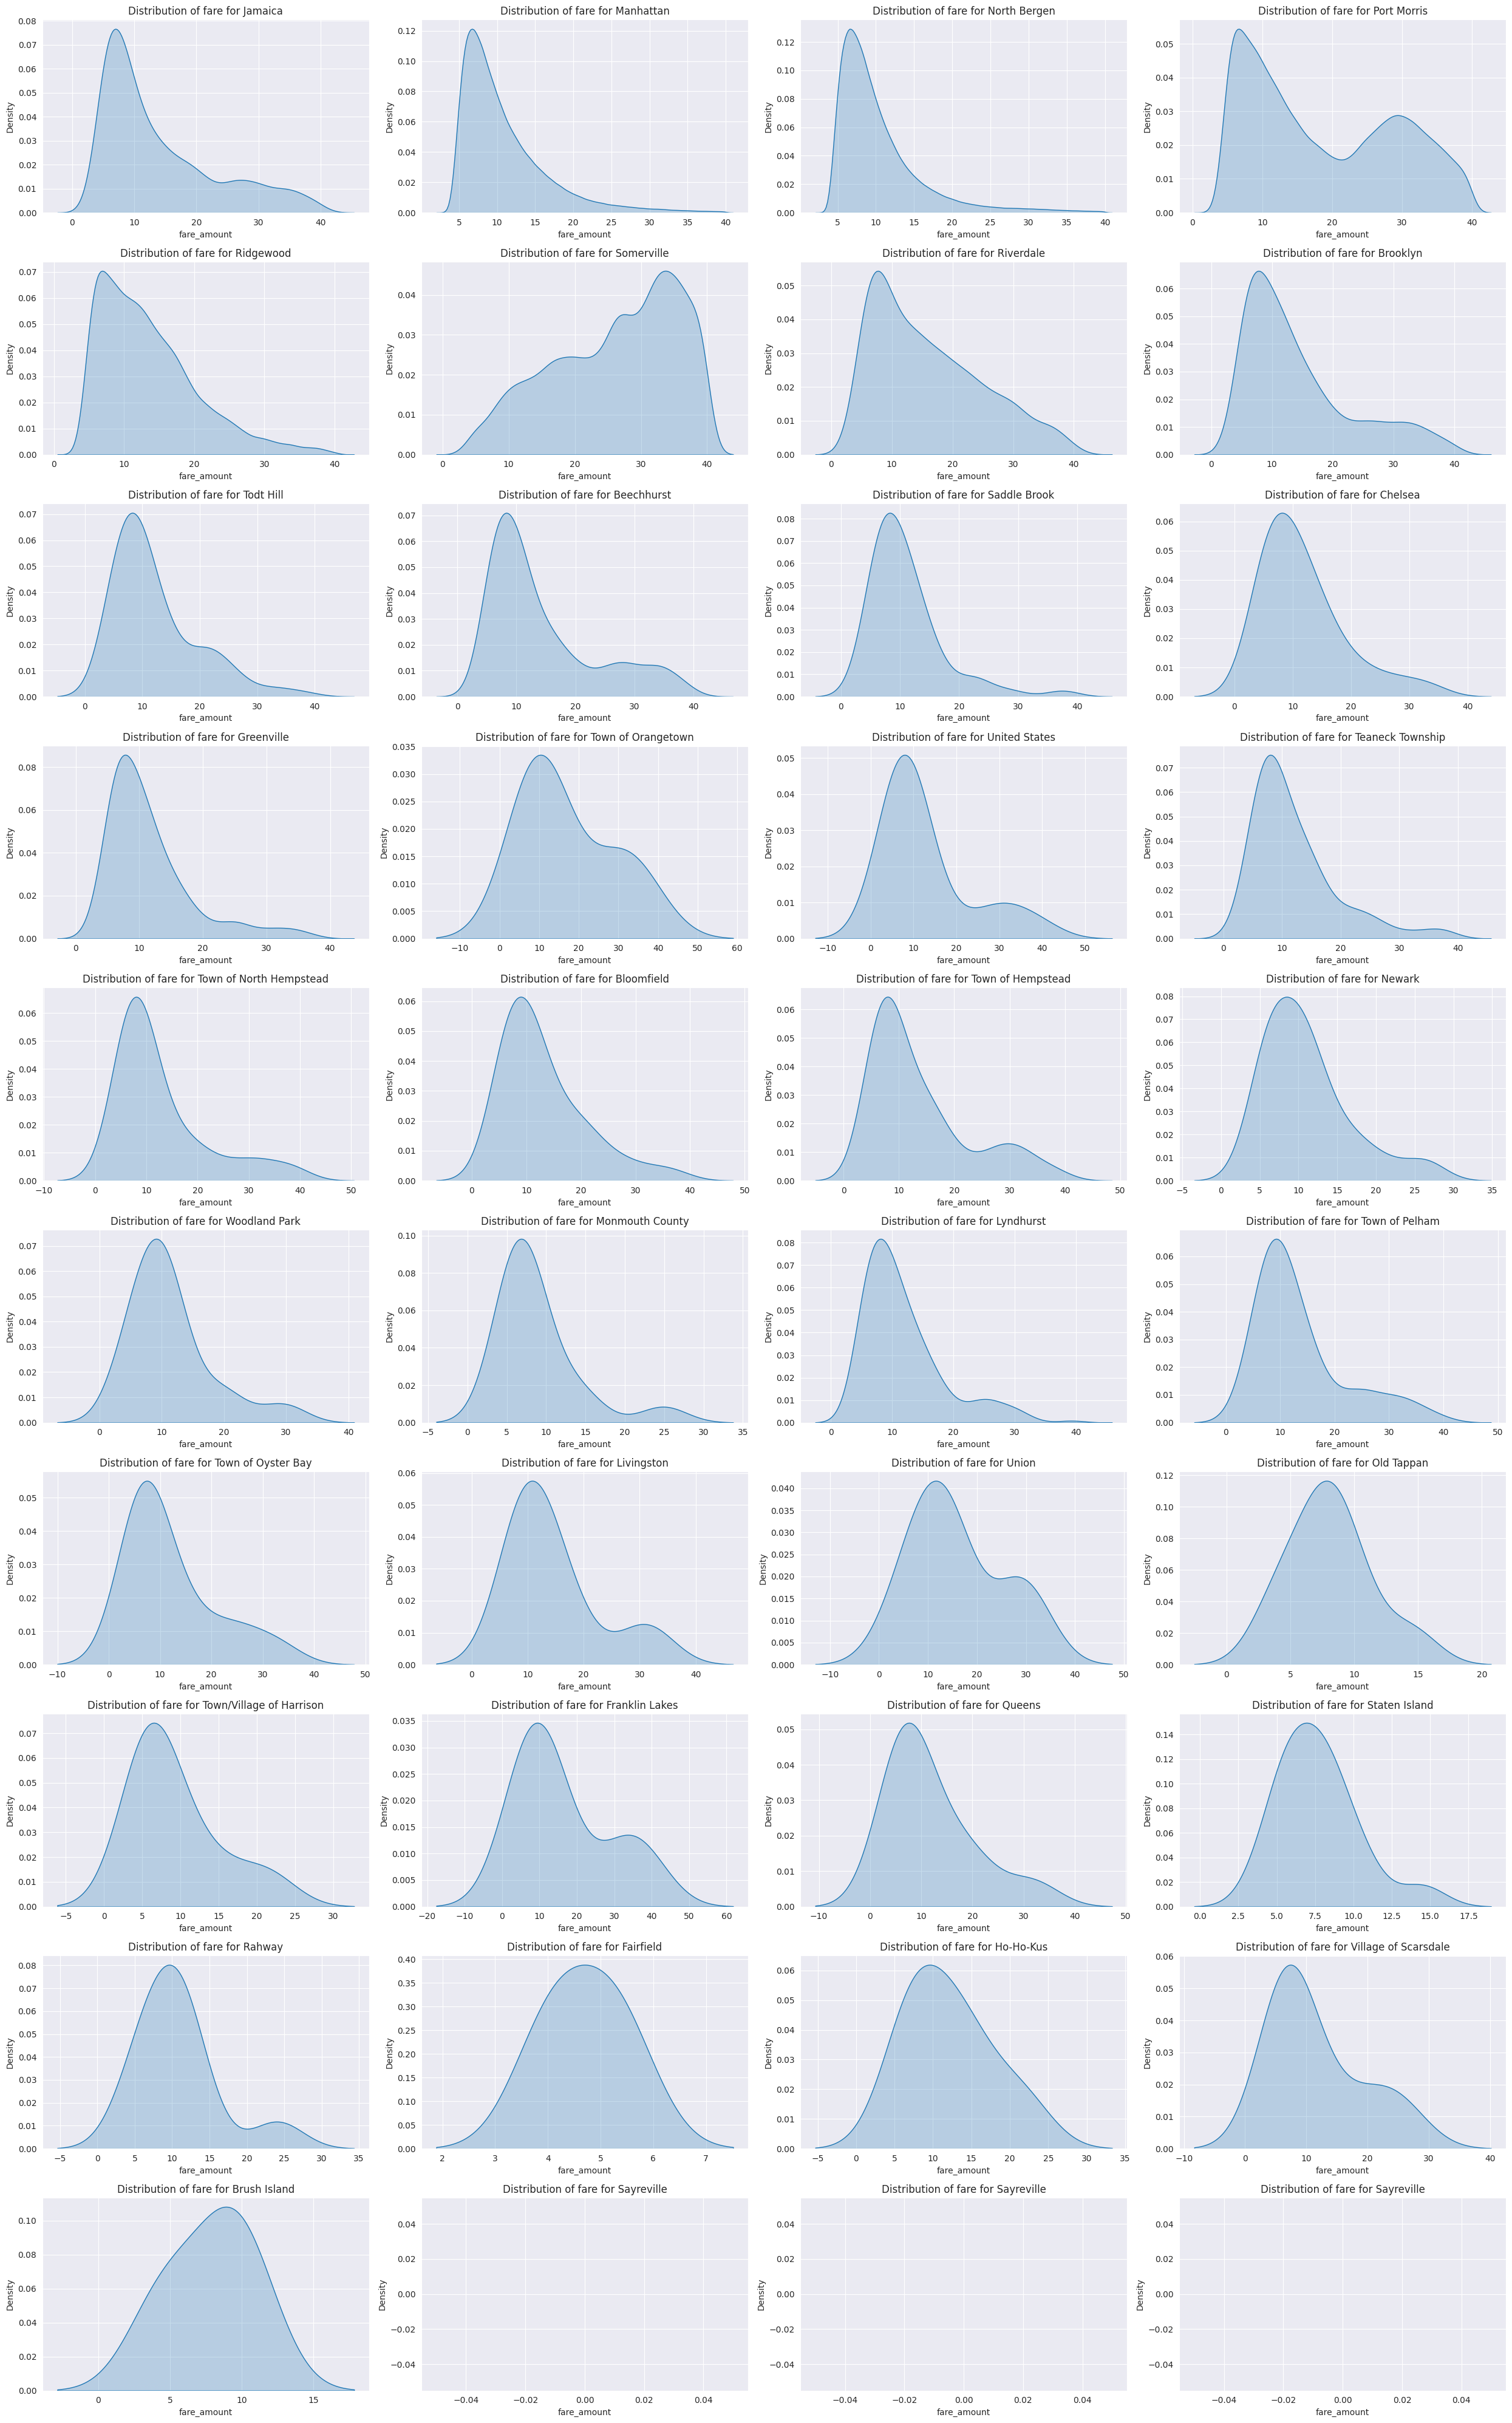

In [ ]:
areas = df['pickup_area'].unique()

fig, axes = plt.subplots(10, 4, figsize=(25, 40))
for row in range(10):
  for col in range(4):
    try: area = areas[(4*row)+col]
    except:  area = areas[-1]

    sns.kdeplot(ax=axes[row, col], data=df[df['pickup_area'] == area]['fare_amount'], fill=True)
    axes[row, col].set_title('Distribution of fare for {}'.format(area))

plt.tight_layout()
plt.show()

<ipython-input-12-713107ecc51a>:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[row, col], data=df[df['dropoff_area'] == area]['fare_amount'], fill=True)
<ipython-input-12-713107ecc51a>:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[row, col], data=df[df['dropoff_area'] == area]['fare_amount'], fill=True)
<ipython-input-12-713107ecc51a>:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[row, col], data=df[df['dropoff_area'] == area]['fare_amount'], fill=True)
<ipython-input-12-713107ecc51a>:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[row, col], data=df[df['dropoff_area'] == area]['fare_amount'], fill=True)


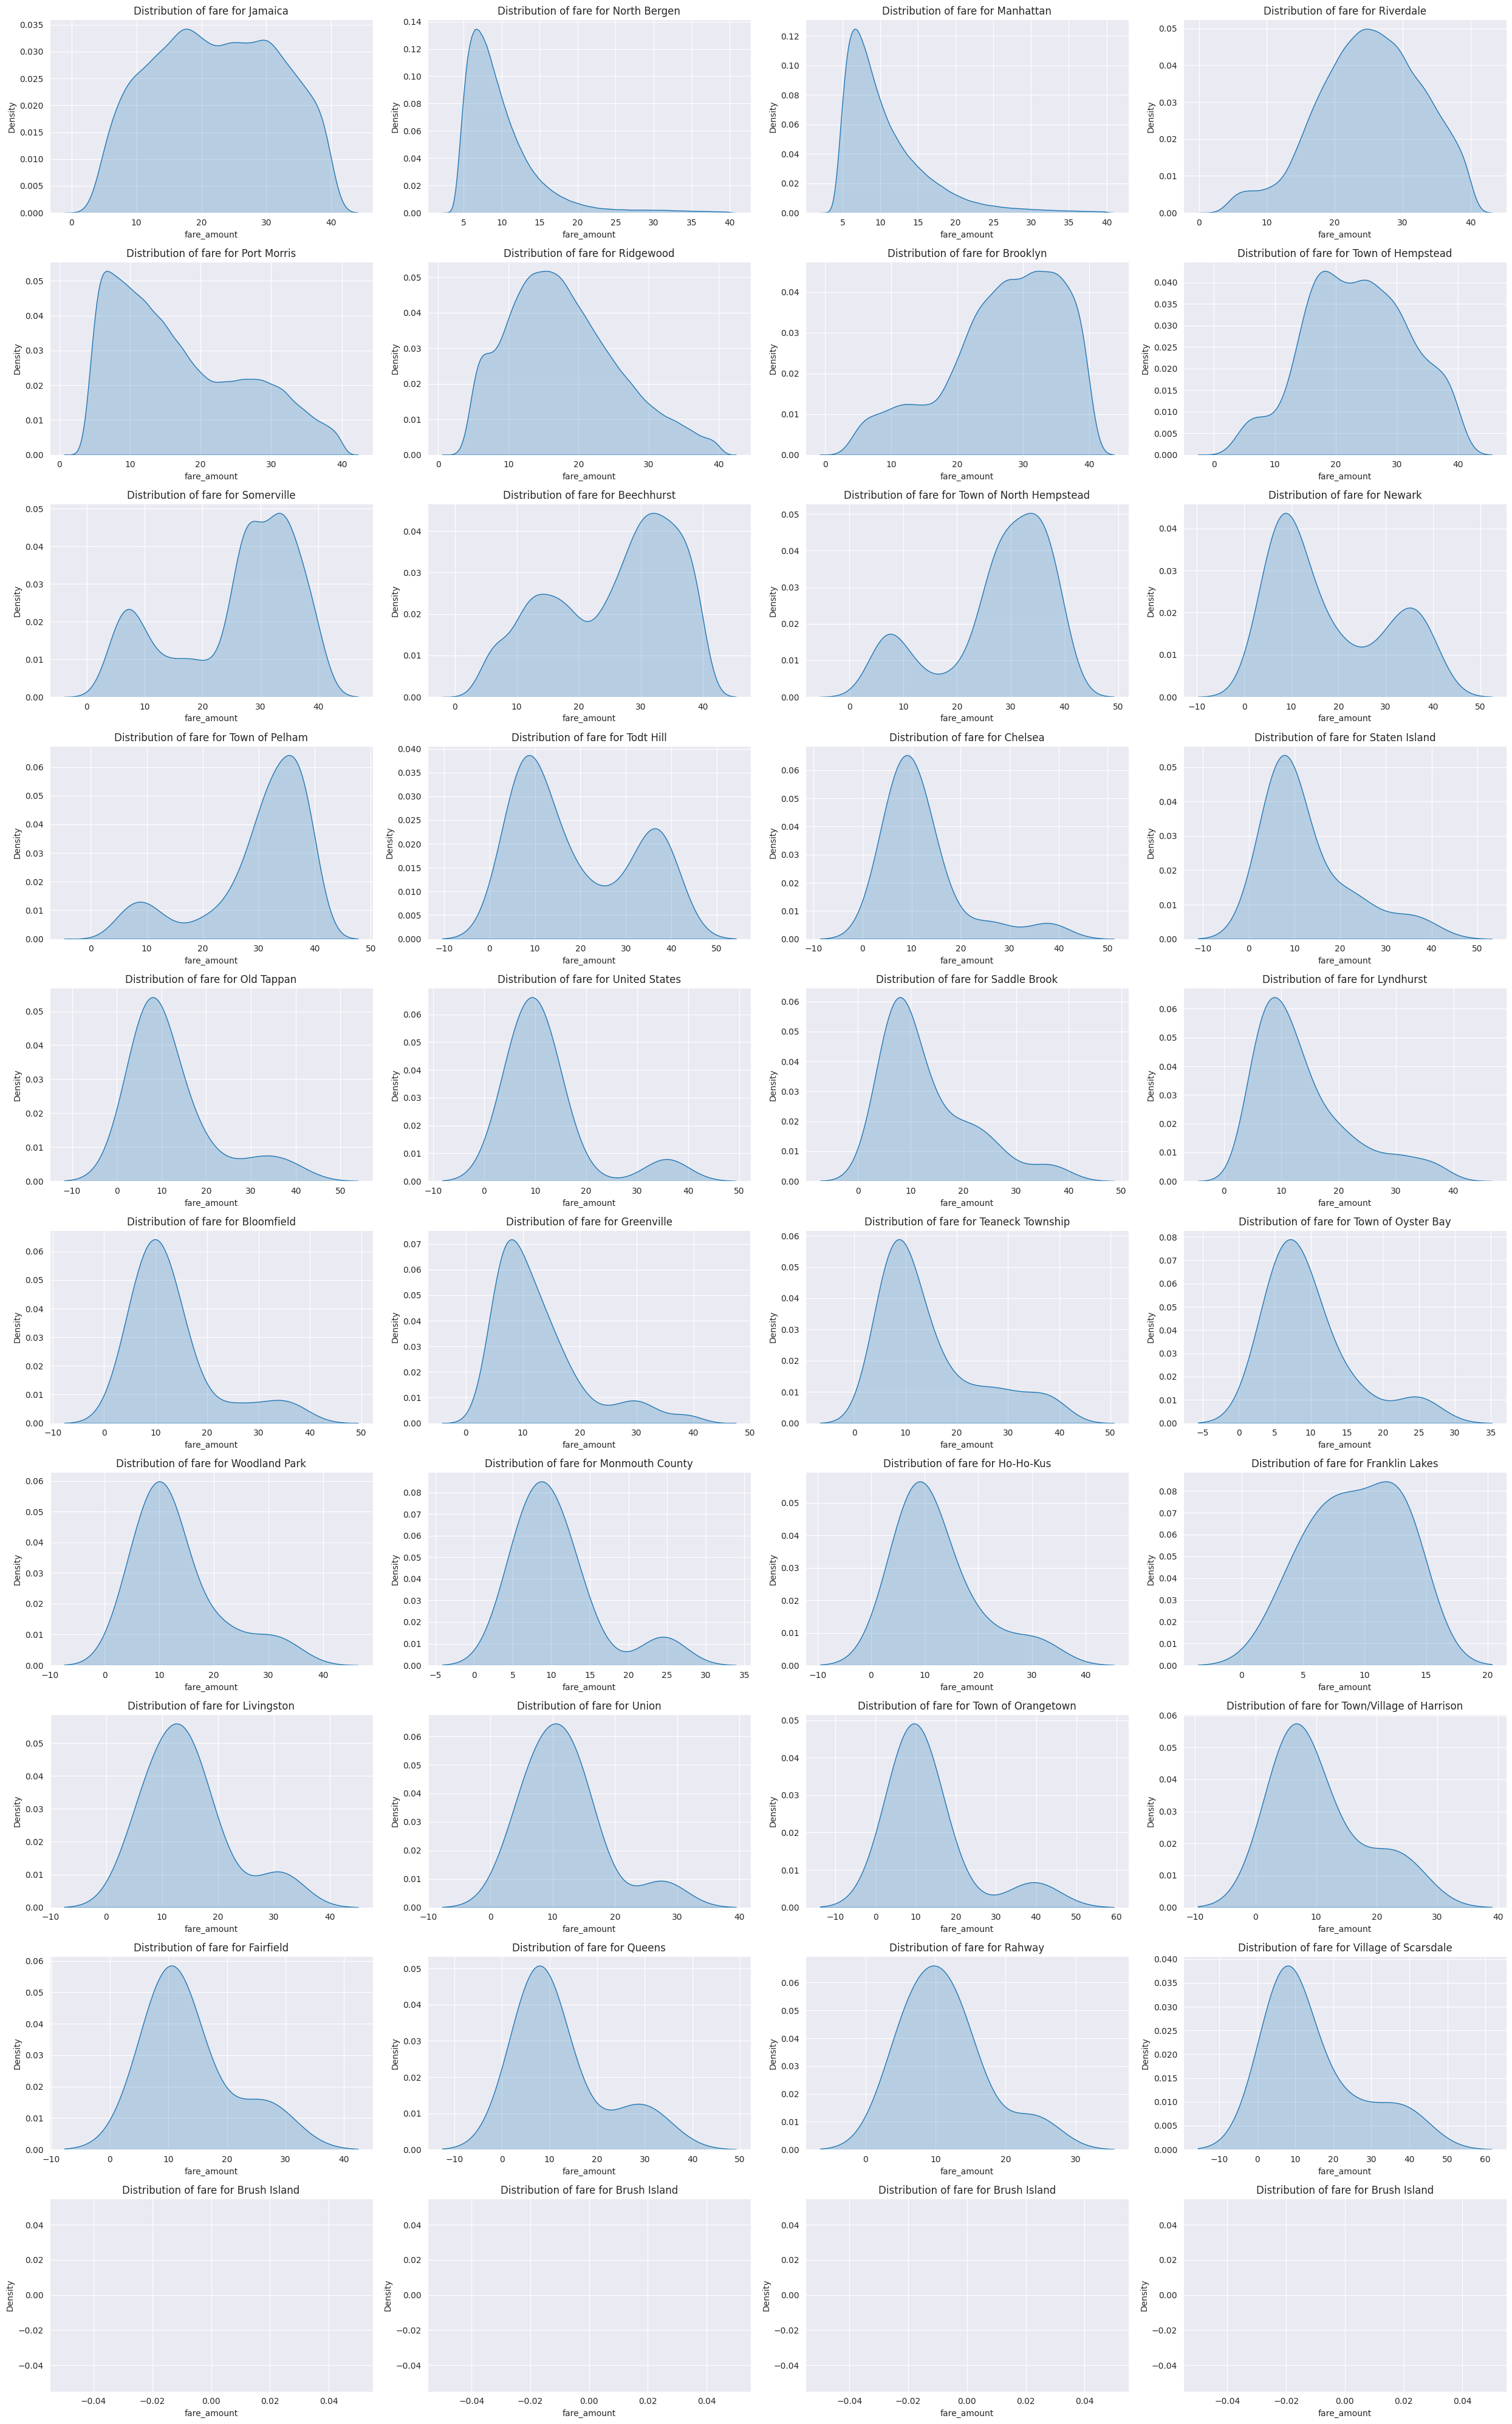

In [ ]:
areas = df['dropoff_area'].unique()

fig, axes = plt.subplots(10, 4, figsize=(25, 40))
for row in range(10):
  for col in range(4):
    try: area = areas[(4*row)+col]
    except:  area = areas[-1]

    sns.kdeplot(ax=axes[row, col], data=df[df['dropoff_area'] == area]['fare_amount'], fill=True)
    axes[row, col].set_title('Distribution of fare for {}'.format(area))

plt.tight_layout()
plt.show()

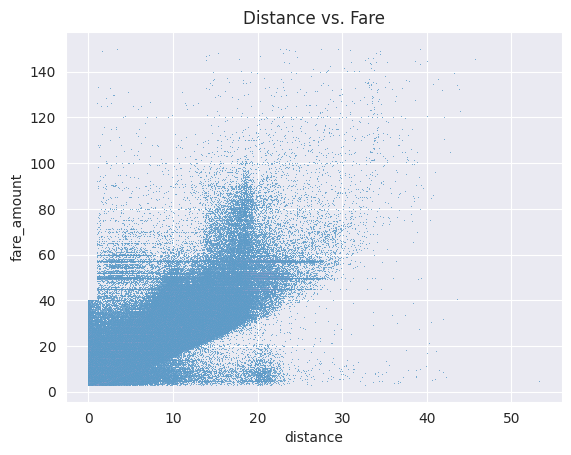

In [18]:
plt.title('Distance vs. Fare')
sns.scatterplot(data=df, x='distance', y='fare_amount', s=.5, alpha=1)
plt.show()

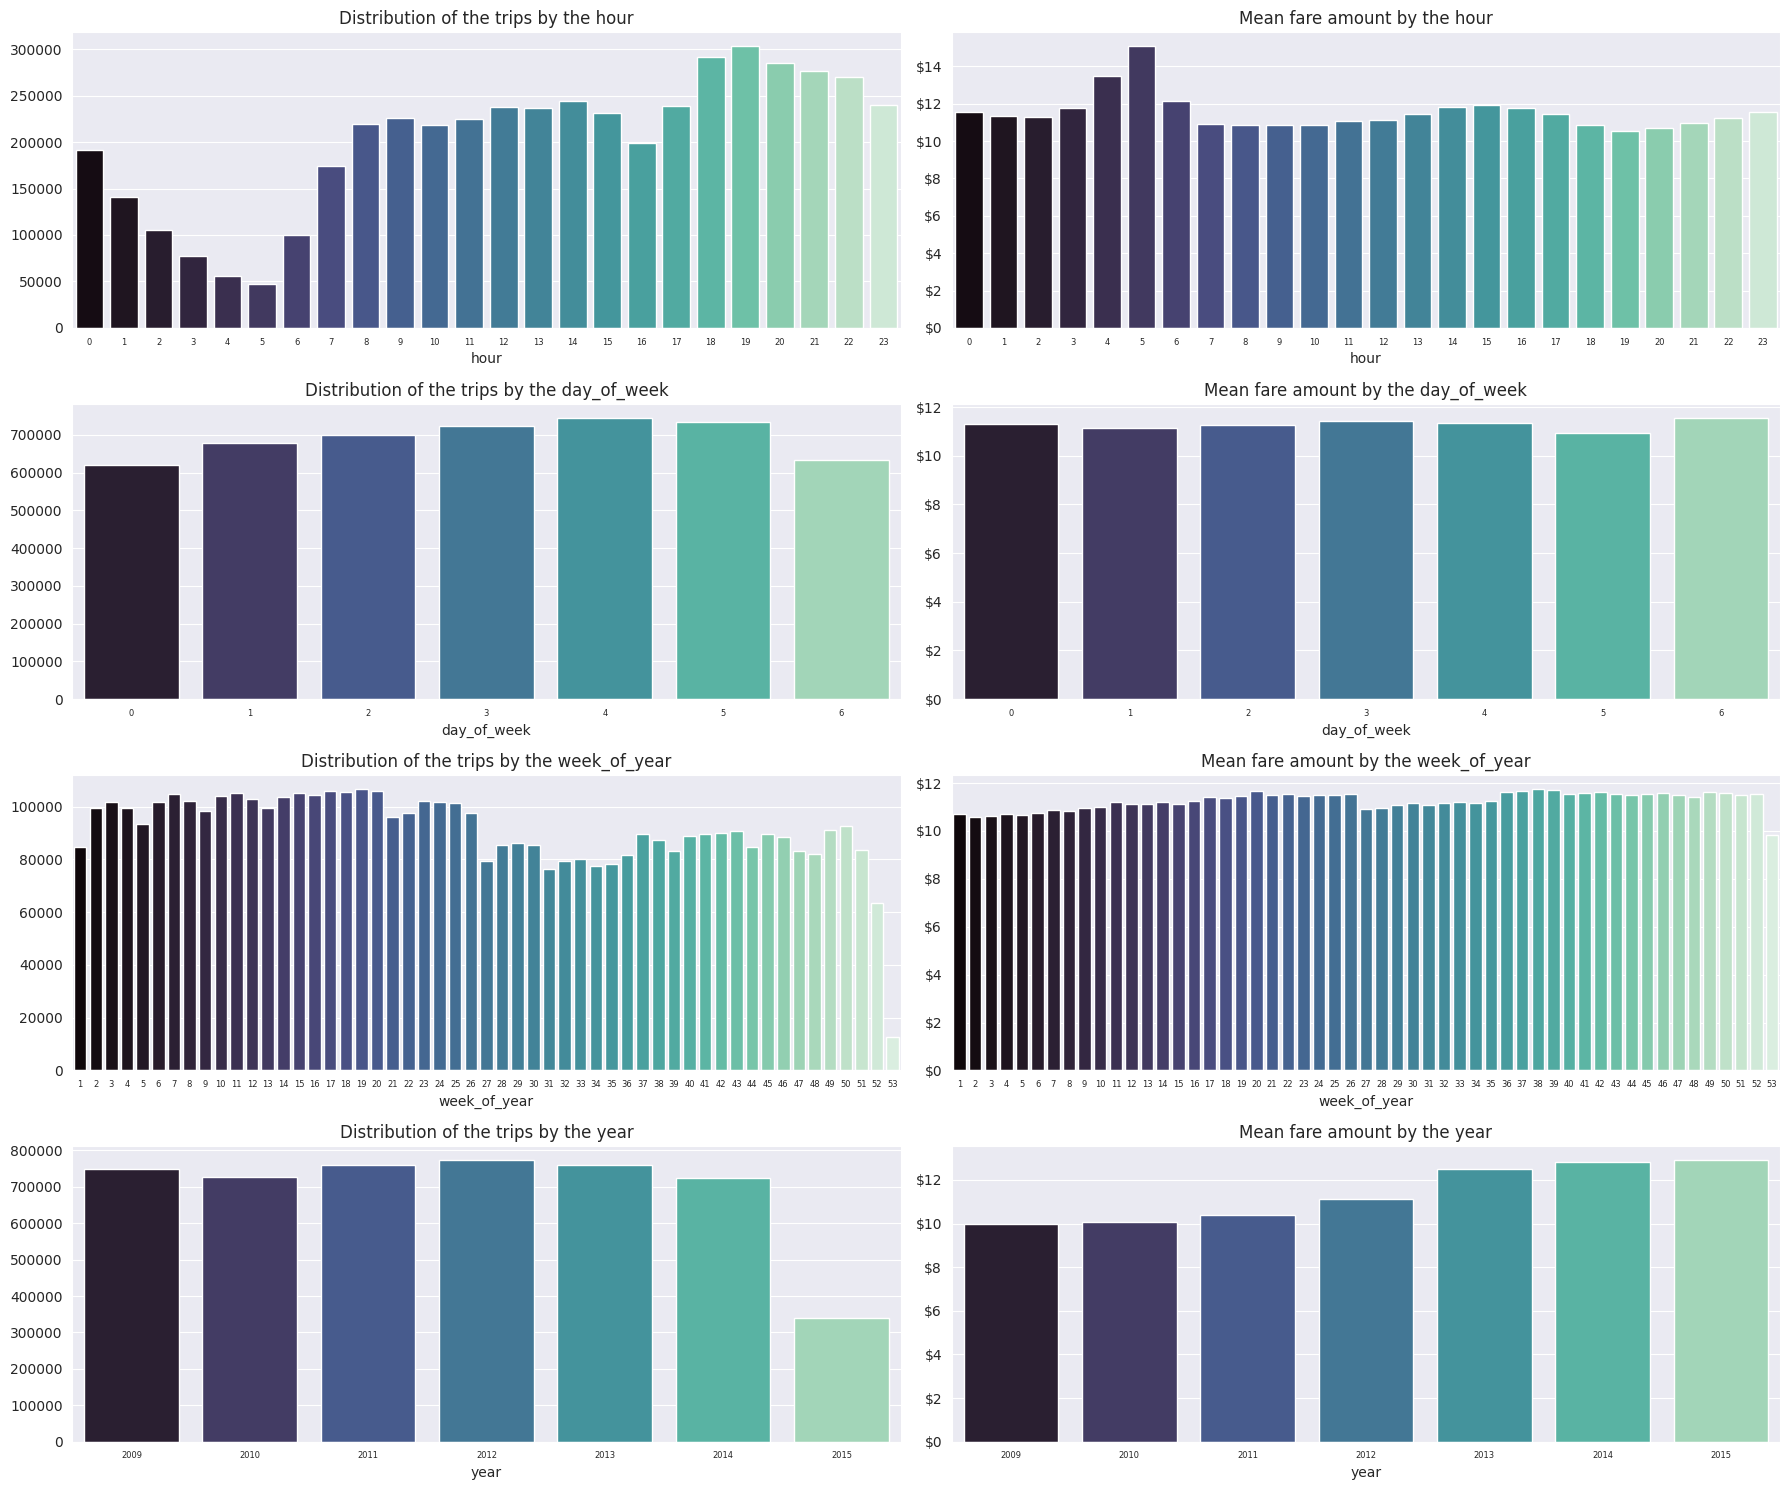

In [22]:
features = ['hour', 'day_of_week', 'week_of_year', 'year']

plt.rc('xtick', labelsize=6)
fig, axes = plt.subplots(len(features), 2, figsize=(18, 15))
for row, feature in zip(range(len(features)), features):
  sns.barplot(ax=axes[row,0], x=df.groupby(feature)['fare_amount'].count().index, y=df.groupby(feature)['fare_amount'].count().values, palette='mako')
  axes[row,0].set_title('Distribution of the trips by the {}'.format(feature))
  sns.barplot(ax=axes[row,1], x=df.groupby(feature)["fare_amount"].mean().index, y=df.groupby(feature)["fare_amount"].mean().values, palette='mako')
  axes[row,1].set_title('Mean fare amount by the {}'.format(feature))
  axes[row,1].yaxis.set_major_formatter('${x:1.0f}')

plt.tight_layout()

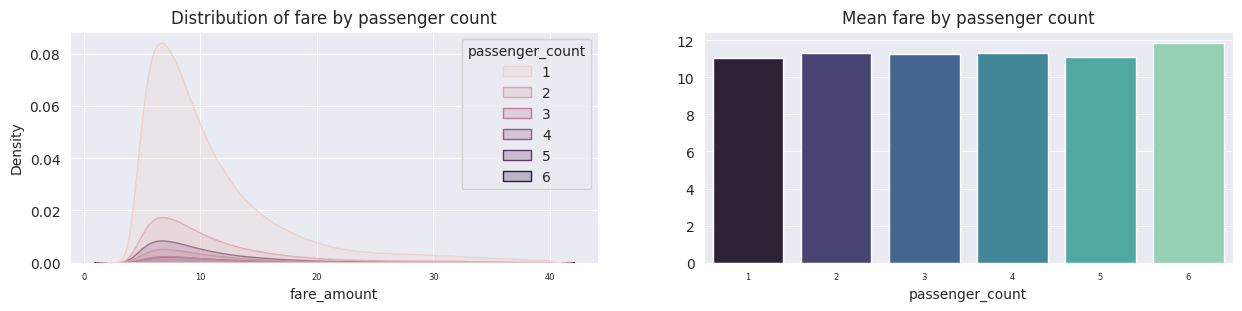

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
sns.kdeplot(ax=axes[0], data=df[df['fare_amount'] < 50], x='fare_amount', hue='passenger_count', fill=True)
axes[0].set_title('Distribution of fare by passenger count'.format(feature))
sns.barplot(ax=axes[1], x=df.groupby('passenger_count')['fare_amount'].mean().index, y=df.groupby('passenger_count')['fare_amount'].mean().values, palette='mako')
axes[1].set_title('Mean fare by passenger count'.format(feature))
plt.show()

### Data Writing

In [ ]:
#One-Hot encoding
pickup_dummies = pd.get_dummies(df['pickup_area'], prefix='dropoff_area', drop_first=True)
dropoff_dummies = pd.get_dummies(df['dropoff_area'], prefix='dropoff_area', drop_first=True)
dummies = pd.concat([pickup_dummies, dropoff_dummies], axis=1)

#clean_df = df.drop(['pickup_area', 'dropoff_area', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1)
clean_df2 = pd.concat([df, dummies], axis=1).drop(['pickup_area', 'dropoff_area', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1)

In [ ]:
clean_df2.to_csv("./Data/clean_data.csv")
#clean_df.to_csv("./Data/clean_df.csv")

### Modeling

##### Linear Regression

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
print('R-squared on training: {}\nR-squared on validation: {} (MAE = {})'.format(lr.score(X_train, y_train), lr.score(X_val, y_val), mean_absolute_error(y_val, y_pred_lr)))

R-squared on training: 0.7262949903610578
R-squared on validation: 0.7531315336585781 (MSE = 2.7111121805216984)


In [ ]:
pd.concat([y_val.reset_index(drop=True), pd.Series(y_pred_lr).rename('predictions')], axis=1)

,fare_amount,predictions
0,7.0,8.100587
1,11.5,7.841612
2,4.5,6.105884
3,9.0,10.471739
4,17.5,16.489996
...,...,...
1835238,13.0,8.769931
1835239,7.5,11.411400
1835240,10.5,7.972745
1835241,13.5,10.368710


In [ ]:
lr.coef_

##### Random Forest

In [ ]:
rf = RandomForestRegressor(max_depth=5).fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print('R-squared on training: {}\nR-squared on validation: {} (MAE = {})'.format(rf.score(X_train, y_train), rf.score(X_val, y_val), mean_absolute_error(y_val, y_pred_rf)))

R-squared on training: 0.7645083835956423
R-squared on validation: 0.7794093541540558 (MAE = 2.7962834591564474)


In [ ]:
pd.concat([y_val.reset_index(drop=True), pd.Series(y_pred_rf).rename('predictions')], axis=1)

,fare_amount,predictions
0,7.0,8.277759
1,11.5,8.343388
2,4.5,6.226521
3,9.0,6.226521
4,17.5,14.048916
...,...,...
764275,9.5,8.838109
764276,17.5,13.923330
764277,6.0,6.226521
764278,6.5,6.226521


In [ ]:
rf.feature_importances_

array([8.72319419e-05, 6.26830256e-04, 1.25848062e-02, 2.84296151e-04,
       0.00000000e+00, 2.17476477e-05, 0.00000000e+00, 2.73315293e-06,
       0.00000000e+00, 6.25367642e-04, 7.56855854e-01, 2.28911133e-01])

##### XGBoost

In [ ]:
xgb = XGBRegressor().fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
print('R-squared on training: {}\nR-squared on validation: {} (MAE = {})'.format(xgb.score(X_train, y_train), xgb.score(X_val, y_val), mean_absolute_error(y_val, y_pred_xgb)))

In [ ]:
pd.concat([y_val.reset_index(drop=True), pd.Series(y_pred_xgb).rename('predictions')], axis=1)

In [ ]:
xgb.feature_importances_